In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
# used for linear mapping...
def linear_mapping(img):
    return (img - img.min()) / (img.max() - img.min())

# pre-processing the image...
def pre_process(img):
    # get the size of the img...
    height, width = img.shape
    # intensity normalization
    img = np.log(img + 1)
    img = (img - np.mean(img)) / (np.std(img) + 1e-5)
    # Apply the cosine window
    window = window_func_2d(height, width)
    img = img * window

    return img

# cosine window generation function
def window_func_2d(height, width):
    win_col = np.hanning(width)
    win_row = np.hanning(height)
    mask_col, mask_row = np.meshgrid(win_col, win_row)

    win = mask_col * mask_row

    return win

def random_warp(img):
    a = -180 / 16
    b = 180 / 16
    r = a + (b - a) * np.random.uniform()
    # rotate the image...
    matrix_rot = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), r, 1)
    img_rot = cv2.warpAffine(np.uint8(img * 255), matrix_rot, (img.shape[1], img.shape[0]))
    img_rot = img_rot.astype(np.float32) / 255
    return img_rot

In [ ]:
# alpha value
lr = 0.125
# variance for the target Gaussian response
sigma = 100
# number of frames to be used for the pre-training
num_pretrain =  1
# rotation augmentation?
rotate = True

In [ ]:
class mosse:
    def __init__(self, lr, sigma, num_pretrain, rotate, img_path):
        # get arguments..
        self.lr = lr
        self.sigma = sigma
        self.num_pretrain = num_pretrain
        self.rotate = rotate

        self.img_path = img_path
        # get the img lists...
        self.frame_lists = self._get_img_lists(self.img_path)
        self.frame_lists.sort()


    # pre train the filter on the first frame...
    def _pre_training(self, init_frame, G):
        height, width = G.shape
        fi = cv2.resize(init_frame, (width, height))
        # pre-process img..
        fi = pre_process(fi)
        Ai = G * np.conjugate(np.fft.fft2(fi))
        Bi = np.fft.fft2(init_frame) * np.conjugate(np.fft.fft2(init_frame))

        # pre-training sequence
        for _ in range(self.num_pretrain):
            if self.rotate:
                fi = pre_process(random_warp(init_frame))
            else:
                fi = pre_process(init_frame)
            Ai = Ai + G * np.conjugate(np.fft.fft2(fi))
            Bi = Bi + np.fft.fft2(fi) * np.conjugate(np.fft.fft2(fi))
        
        return Ai, Bi
    
    # start to do the object tracking...
    def start_tracking(self, init_gt):
        # get the image of the first frame... (read as gray scale image...)
        init_img = cv2.imread(self.frame_lists[0])
        init_frame = cv2.cvtColor(init_img, cv2.COLOR_BGR2GRAY)
        init_frame = init_frame.astype(np.float32)

        # get the init ground truth.. [x, y, width, height]
        # start to draw the gaussian response...
        response_map = self._get_gauss_response(init_frame, init_gt)

        # start to create the training set ...
        # get the goal..
        g = response_map[init_gt[1]:init_gt[1]+init_gt[3], init_gt[0]:init_gt[0]+init_gt[2]]
        fi = init_frame[init_gt[1]:init_gt[1]+init_gt[3], init_gt[0]:init_gt[0]+init_gt[2]]
        G = np.fft.fft2(g)

        # start to do the pre-training...
        Ai, Bi = self._pre_training(fi, G)

        # start the tracking...
        for idx in range(len(self.frame_lists)):
            current_frame = cv2.imread(self.frame_lists[idx])
            frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
            frame_gray = frame_gray.astype(np.float32)
            if idx == 0:
                Ai = self.lr * Ai
                Bi = self.lr * Bi
                pos = init_gt.copy()
                clip_pos = np.array([pos[0], pos[1], pos[0]+pos[2], pos[1]+pos[3]]).astype(np.int64)
            else:
                Hi = Ai / Bi
                fi = frame_gray[clip_pos[1]:clip_pos[3], clip_pos[0]:clip_pos[2]]
                fi = pre_process(cv2.resize(fi, (init_gt[2], init_gt[3])))
                Gi = Hi * np.fft.fft2(fi)
                gi = linear_mapping(np.fft.ifft2(Gi))
                # find the max pos...
                max_value = np.max(gi)
                max_pos = np.where(gi == max_value)
                dy = int(np.mean(max_pos[0]) - gi.shape[0] / 2)
                dx = int(np.mean(max_pos[1]) - gi.shape[1] / 2)
                
                # update the position...
                pos[0] = pos[0] + dx
                pos[1] = pos[1] + dy

                # trying to get the clipped position [xmin, ymin, xmax, ymax]
                clip_pos[0] = np.clip(pos[0], 0, current_frame.shape[1])
                clip_pos[1] = np.clip(pos[1], 0, current_frame.shape[0])
                clip_pos[2] = np.clip(pos[0]+pos[2], 0, current_frame.shape[1])
                clip_pos[3] = np.clip(pos[1]+pos[3], 0, current_frame.shape[0])
                clip_pos = clip_pos.astype(np.int64)

                # get the current fi..
                fi = frame_gray[clip_pos[1]:clip_pos[3], clip_pos[0]:clip_pos[2]]
                fi = pre_process(cv2.resize(fi, (init_gt[2], init_gt[3])))
                # online update...
                Ai = self.lr * (G * np.conjugate(np.fft.fft2(fi))) + (1 - self.lr) * Ai
                Bi = self.lr * (np.fft.fft2(fi) * np.conjugate(np.fft.fft2(fi))) + (1 - self.lr) * Bi
            
            # visualize the tracking process...
            if idx%20 == 0:
              
              cv2.rectangle(current_frame, (pos[0], pos[1]), (pos[0]+pos[2], pos[1]+pos[3]), (255, 0, 0), 2)
              cv2_imshow(current_frame)
              #cv2.waitKey(100)


    # get the ground-truth gaussian reponse...
    def _get_gauss_response(self, img, gt):
        # get the shape of the image..
        height, width = img.shape
        # get the mesh grid...
        xx, yy = np.meshgrid(np.arange(width), np.arange(height))
        # get the center of the object...
        center_x = gt[0] + 0.5 * gt[2]
        center_y = gt[1] + 0.5 * gt[3]
        # cal the distance...
        dist = (np.square(xx - center_x) + np.square(yy - center_y)) / (2 * self.sigma)
        # get the response map...
        response = np.exp(-dist)
        # normalize...
        response = linear_mapping(response)
        return response

    # it will extract the image list 
    def _get_img_lists(self, img_path):
        frame_list = []
        for frame in os.listdir(img_path):
            if os.path.splitext(frame)[1] == '.jpg':
                frame_list.append(os.path.join(img_path, frame)) 
        return frame_list
    


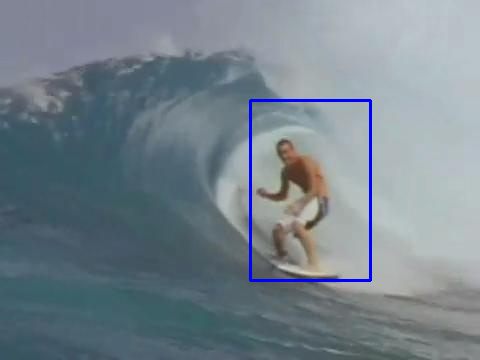

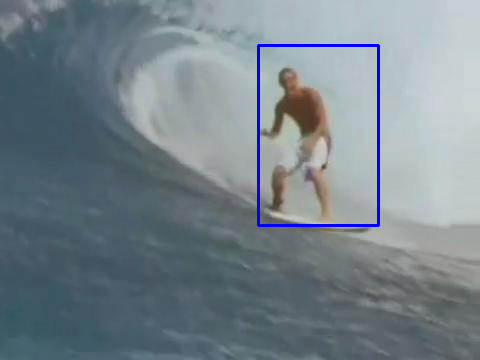

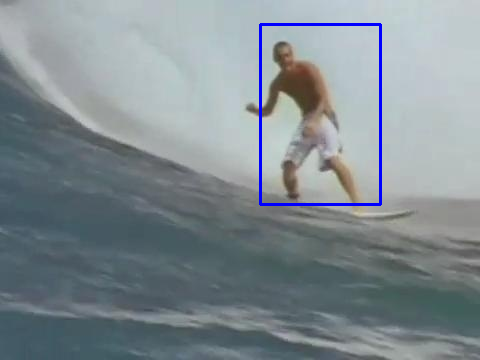

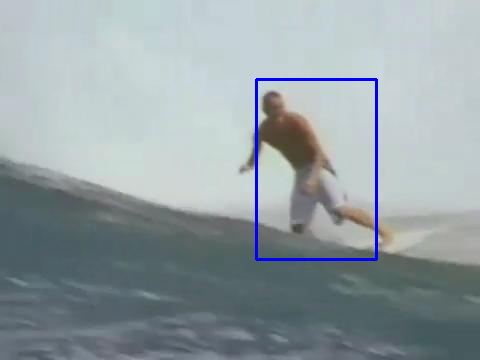

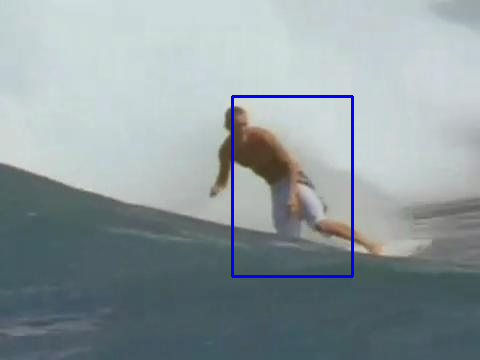

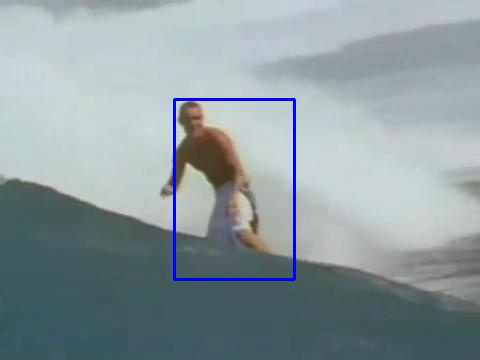

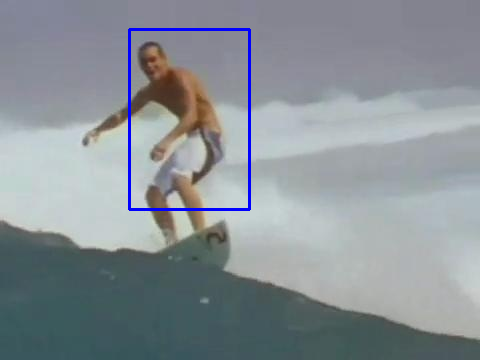

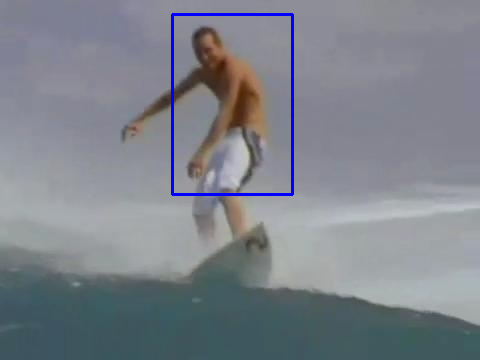

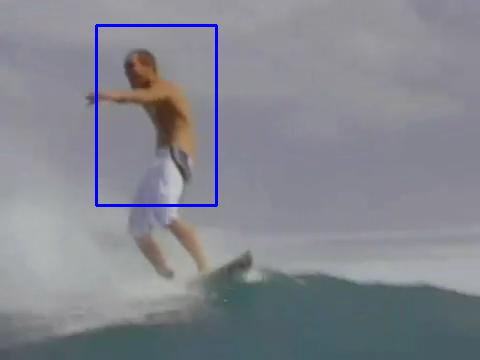

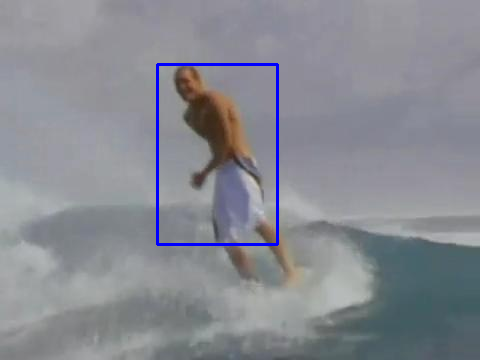

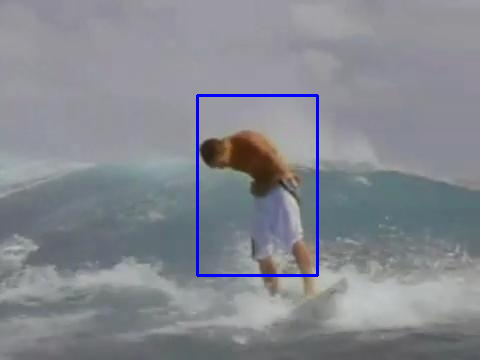

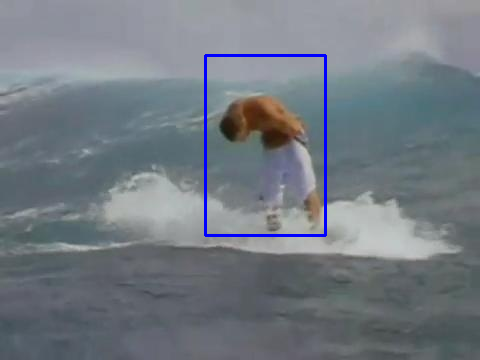

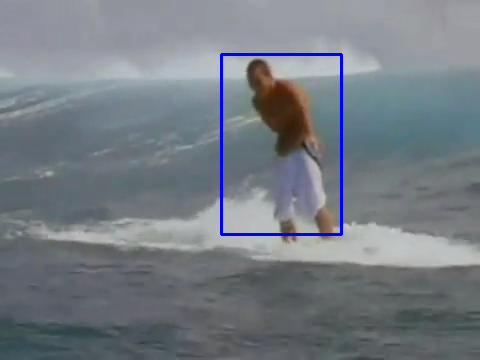

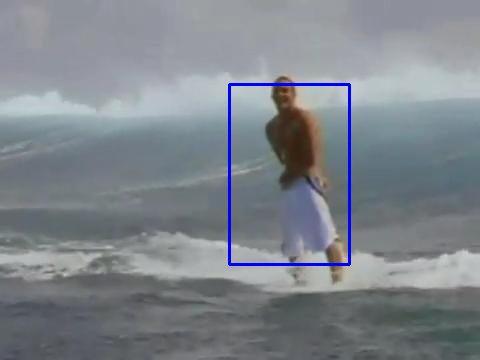

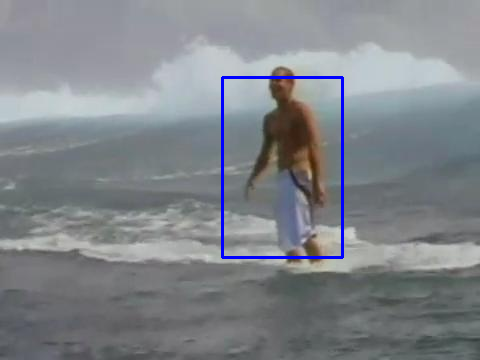

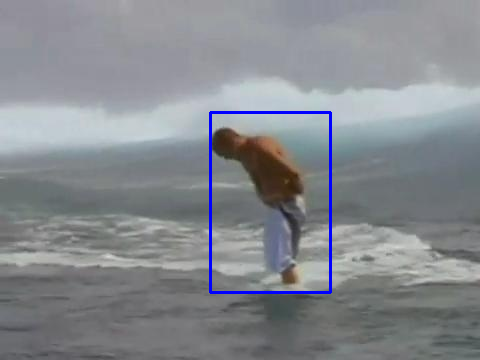

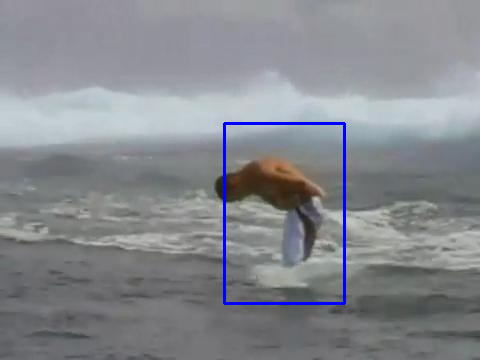

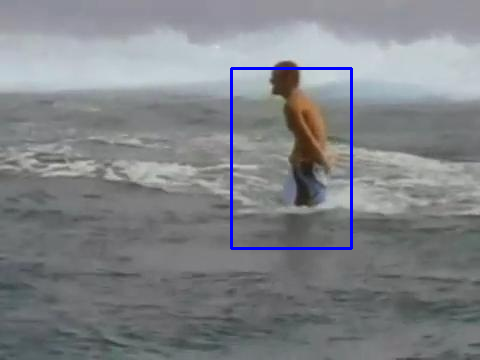

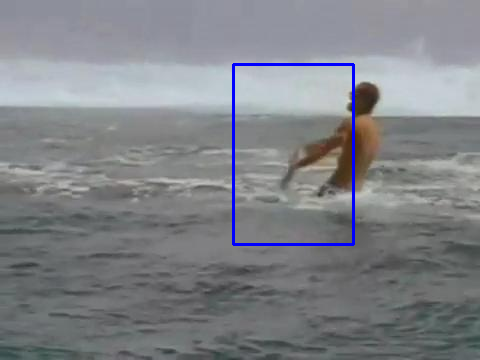

In [ ]:
img_path = '.'
tracker = mosse(lr, sigma, num_pretrain, rotate, img_path)
tracker.start_tracking([250, 100, 120, 180])